In [2]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
from things_evaluation.evaluate import read_embeddings, load_behav, load_sorting, match_behv_sim, evaluate as run_evaluation
from collections import defaultdict
from things_evaluation.load import get_intersection_words_things



# T-SNE

In [5]:
def tsne_transform(embeddings):
    tsne = TSNE()
    X_embedded = tsne.fit_transform(embeddings)
    return X_embedded

In [6]:
def plot(embeddings, ax, title, hue, legend):
    #palette = sns.color_palette("bright", hue.shape[0])
    a = sns.scatterplot(embeddings[:,0], embeddings[:,1], legend=legend, hue=hue, ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])



## Across 1854 objects
Goal: see if plain LM embeddings (and W2V) reflect conceptual knowledge 

Implications:
if clusters -> embeddings reflect knowledge
if messy -> embeddings dont reflect knowledge

In [30]:
matching = 'word'
matching_words = get_intersection_words_things(None, 'wikidumps', matching)
keep_categories = True

../../data/thinga/wikidumps/decontext/bert-base/0/word/mean/1/decontextualized_sense_embeddings.txt 1852
w2v 1572
glove 1557


## BERT-base Layer 1

In [75]:
combs = {
    'bert-base': [0,1,5,10,12],
    'gpt-2': [0,1,5,10,12]
}
results = defaultdict(lambda: defaultdict(list))

for model, layers in combs.items():
    for layer in layers:
        path = f'../../data/thinga/wikidumps/decontext/{model}/{layer}/{matching}/mean/all/decontextualized_sense_embeddings.txt'
        embeddings = read_embeddings(path, matching, matching_words, 1, False, keep_categories)
        categories = embeddings['category']
        embeddings = embeddings.drop(columns=['category'])
        results[model][layer] = (tsne_transform(embeddings), categories)

## Word2Vec

In [76]:
path = f'../../data/thinga/static/w2v/word2vec-google-news-300/embeddings.txt'
embeddings = read_embeddings(path, matching, matching_words, None, False, keep_categories)
categories = embeddings['category']
embeddings = embeddings.drop(columns=['category'])
tsne_embeddings = tsne_transform(embeddings)

/home/hannes/anaconda3/envs/cognival_decon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hannes/anaconda3/envs/cognival_decon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hannes/anaconda3/envs/cognival_decon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword wil

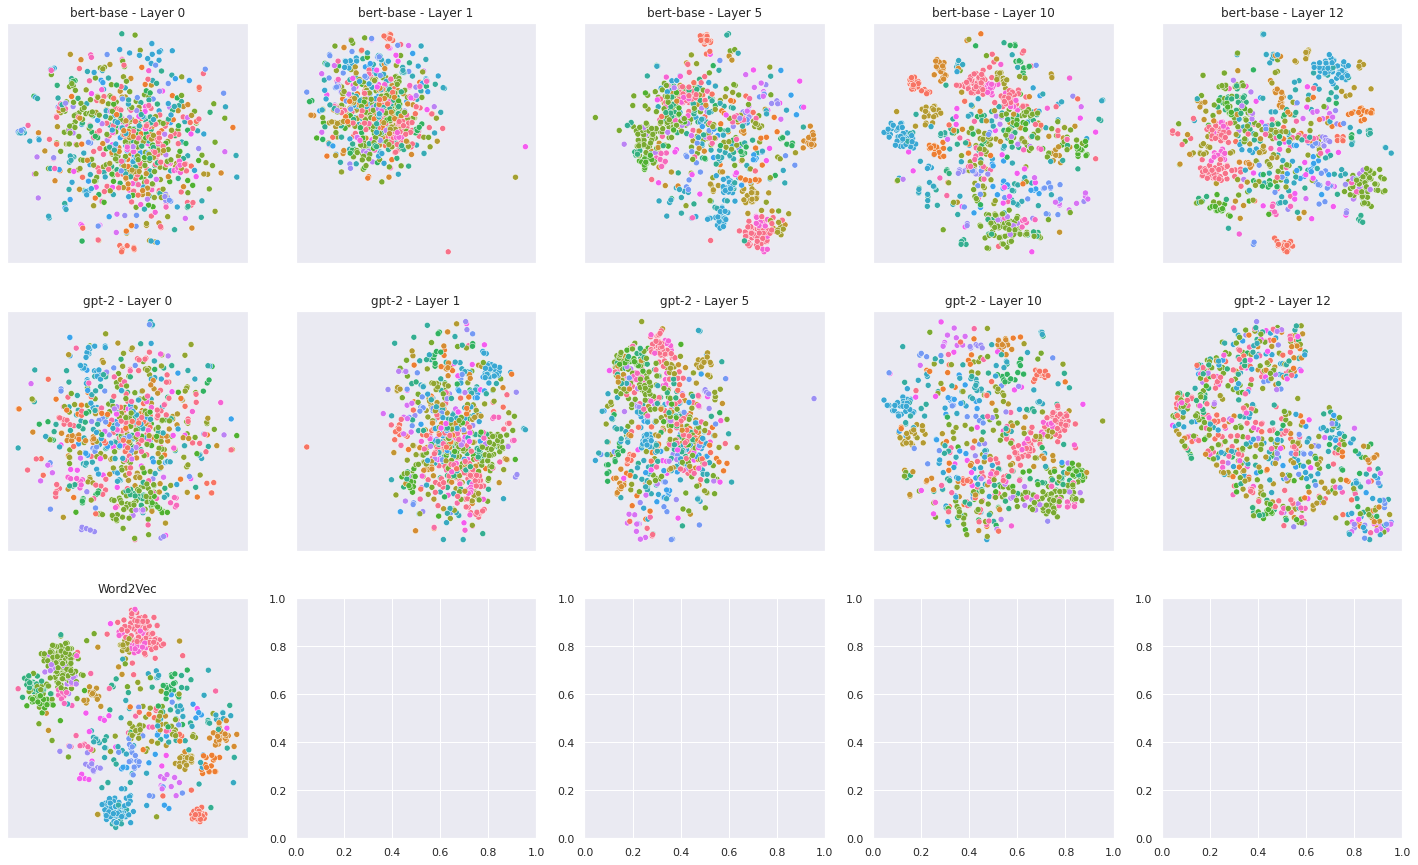

In [83]:
fig, axes = plt.subplots(3,5, figsize=(25, 15))

for i, model_mapping in enumerate(combs.items()):
    model = model_mapping[0]
    layers = model_mapping[1]
    for j, layer in enumerate(layers):
        X_embedded, hue = results[model][layer]
        plot(X_embedded, axes[i][j], f'{model} - Layer {layer}', hue, False)

plot(tsne_embeddings, axes[2][0], 'Word2Vec', categories, False)

# Across contexts for homonyms -> maybe fine tuned on word similarity

In [3]:
def file_to_lines(f):
    with open(f, 'r') as input_file:
        for line in input_file:
            yield line

def load_embeddings(embeddings_path, synset_word_levels, max_number_of_embeddings):
    counter = defaultdict(lambda: 0)

    embeddings = defaultdict(list)
    for line in file_to_lines(embeddings_path):
        splitted_line = line.split(';')
        word_found_in_sentence = splitted_line[0]
        key = None
        if synset_word_levels == 'word':
            key = word_found_in_sentence

        if max_number_of_embeddings and counter[key] >= max_number_of_embeddings:
            continue

        embedding = splitted_line[2].split(' ')
        embedding = np.asarray([float(value) for value in embedding])
        embeddings[key].append(embedding)
        counter[key] += 1
    
    for key in embeddings:
        embeddings[key] = np.vstack(embeddings[key])

    return embeddings

In [7]:
combs = [1, 10]
results = defaultdict(list)

for layer in combs:
    path = f'../../data_fine_tune/extractions_{layer}.txt'
    all_embeddings = load_embeddings(path, 'word', 50)

    embeddings = []
    labels = []

    for key in ['mouse', 'computer', 'rat', 'bat', 'baseball', 'dog', 'cat']:
        for embedding in all_embeddings[key]:
            labels.append(key)
            embeddings.append(embedding)

    embeddings = np.vstack(embeddings)

    trans_embeddings = tsne_transform(embeddings)
    results[layer] = (trans_embeddings, labels)


/home/hannes/anaconda3/envs/cognival_decon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hannes/anaconda3/envs/cognival_decon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


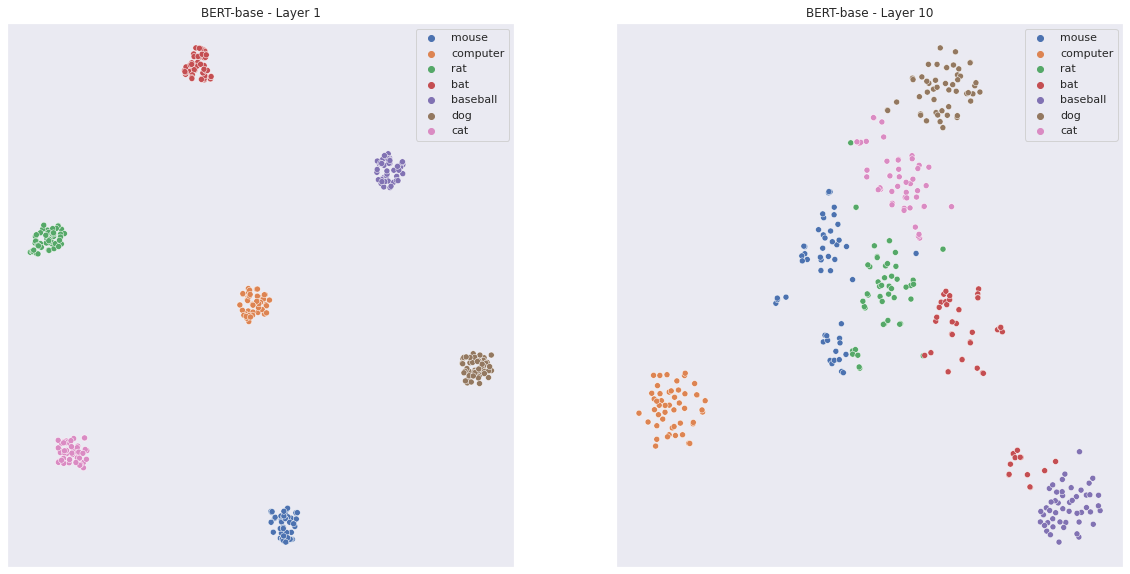

In [8]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

for i, layer in enumerate(combs):
    embeddings, labels = results[layer]
    plot(embeddings, axes[i], f'BERT-base - Layer {layer}', labels, True)